## Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sk_version
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from category_encoders.hashing import HashingEncoder
from lightgbm import LGBMClassifier
from sklearn.inspection import permutation_importance

NumPy version: 2.1.3
Pandas version: 2.3.3
Matplotlib version: 3.10.0
Scikit-learn version: 1.6.1


### Описание задачи

Цель проекта - построить модель машинного обучения, способную прогнозировать целевую переменную target, отражающую важное бизнес-событие. Задача относится к области бинарной классификации:
модель должна определить вероятность попадания объекта в класс 1 или класс 0.

### Особенности бизнес-процесса и данных

Пользователи совершают последовательности финансовых операций: депозиты, заимствования, погашения, ликвидации, операции с обеспечением. Каждый пример в датасете описывает состояние пользователя на определённый момент.

Признаки включают:
- риск-метрики (risk_factor, max_risk_factor, avg_risk_factor и др.) 
- количество операций;
- данные о транзакциях;
- финансовые значения.

### Характеристики данных, которые могут негативно повлиять на исследование

1. Высокая размерность признаков.
2. Возможно наличие корреляции между нецелевыми признаками.
3. Имеет место дисбаланс классов — доля класса “1” около 37%, что требует корректных метрик.
4. Смешанные типы данных - категории, числа.
5. Возможно наличие пропусков и выбросов.

### Предлагаемый подход

1. Первичный анализ данных:
- загрузка данных;
- анализ пропусков и дубликатов;
- оценка распредения целевой переменной.

2. Разделение данных на обучающую и тестовую выборки для корректной оценки модели.

3. Предобработка:
- заполнение пропусков и обработка выбросов, если они имеют место;
- энкодинг категориальных признаков;
- генерирование новых признаков;
- мастабирование данных для улучшения работы алгоритмов;
- отбор признаков с использованием различных методов - построение моделей, фильтрационные методы.

4. Выбор модели:
- базовая модель (Logistic Regression);
- ансамблевые модели (RandomForest, GradientBoosting, LightGBM).

5. Выбор метрик:
- Accuracy / Recall / Precision;
- ROC-AUC;
- F1-мера.

6. Обучение базовой модели на тренировочной выборке и оценка качества ее предсказаний на валидационной.

7. Подбор гиперпараметров для различных моделей.

8. Обучение финальной модели на всей обучающей выборке с оптимальными гиперпараметрами.

9. Оценка производительности.

## Первичный анализ данных.

### Загрузка данных и вывод базовой информации о наборе данных

In [2]:
df = pd.read_parquet("dataset.parquet")
print("Данные успешно загружены", end='\n\n')

print("Размер датасета (строки, столбцы):")
print(df.shape)
display(df.head())

Данные успешно загружены

Размер датасета (строки, столбцы):
(442961, 78)


,borrow_block_number,borrow_timestamp,wallet_address,first_tx_timestamp,last_tx_timestamp,wallet_age,incoming_tx_count,outgoing_tx_count,net_incoming_tx_count,total_gas_paid_eth,avg_gas_paid_per_tx_eth,risky_tx_count,risky_unique_contract_count,risky_first_tx_timestamp,risky_last_tx_timestamp,risky_first_last_tx_timestamp_diff,risky_sum_outgoing_amount_eth,outgoing_tx_sum_eth,incoming_tx_sum_eth,outgoing_tx_avg_eth,incoming_tx_avg_eth,max_eth_ever,min_eth_ever,total_balance_eth,risk_factor,total_collateral_eth,total_collateral_avg_eth,total_available_borrows_eth,total_available_borrows_avg_eth,avg_weighted_risk_factor,risk_factor_above_threshold_daily_count,avg_risk_factor,max_risk_factor,borrow_amount_sum_eth,borrow_amount_avg_eth,borrow_count,repay_amount_sum_eth,repay_amount_avg_eth,repay_count,borrow_repay_diff_eth,deposit_count,deposit_amount_sum_eth,time_since_first_deposit,withdraw_amount_sum_eth,withdraw_deposit_diff_if_positive_eth,liquidation_count,time_since_last_liquidated,liquidation_amount_sum_eth,market_adx,market_adxr,market_apo,market_aroonosc,market_aroonup,market_atr,market_cci,market_cmo,market_correl,market_dx,market_fastk,market_fastd,market_ht_trendmode,market_linearreg_slope,market_macd_macdext,market_macd_macdfix,market_macd,market_macdsignal_macdext,market_macdsignal_macdfix,market_macdsignal,market_max_drawdown_365d,market_natr,market_plus_di,market_plus_dm,market_ppo,market_rocp,market_rocr,unique_borrow_protocol_count,unique_lending_protocol_count,target
0,7711117,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973049.0,199,438,-239,0.397391,0.000981,0,0,999999999,999999999,0,0.0,975.686105,958.353127,1.174111,1.153253,61.680231,0.060948,58.317987,0.000001,44.479139,0.000000,31.575270,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0,0.0,0.0,0,0.000000,6,44.410991,4026.0,0.0,0.0,0,999999999.0,0.0,22.357432,31.489909,-3.914837,67.777778,7.142857,9.047057,111.965749,19.928594,0.878363,31.02392,80.653832,57.459322,1,0.423859,-3.914837,1.326453,1.406507,-3.468973,1.163425,1.212219,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,0,1,1
1,7711123,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973188.0,200,439,-239,0.399063,0.000983,0,0,999999999,999999999,0,0.0,975.686105,958.510238,1.171292,1.150673,61.680231,0.060948,58.317987,0.004953,44.479139,44.479139,31.418863,31.575270,0.000000,0.0,0.000001,0.000001,0.157110,0.157110,1,0.0,0.0,0,0.157110,6,44.410991,4165.0,0.0,0.0,0,999999999.0,0.0,22.357432,31.489909,-3.914837,67.777778,7.142857,9.047057,111.965749,19.928594,0.878363,31.02392,80.653832,57.459322,1,0.423859,-3.914837,1.326453,1.406507,-3.468973,1.163425,1.212219,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,1,1,1
2,7711126,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973238.0,201,440,-239,0.400895,0.000985,0,0,999999999,999999999,0,0.0,975.686105,958.896402,1.168486,1.148379,61.680231,0.060948,58.317987,0.017103,44.479139,44.479139,31.035236,31.497067,0.000387,0.0,0.002477,0.004953,0.543275,0.271637,2,0.0,0.0,0,0.543275,6,44.410991,4215.0,0.0,0.0,0,999999999.0,0.0,22.357432,31.489909,-3.914837,67.777778,7.142857,9.047057,111.965749,19.928594,0.878363,31.02392,80.653832,57.459322,1,0.423859,-3.914837,1.326453,1.406507,-3.468973,1.163425,1.212219,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,1,1,1
3,7711672,1.557205e+09,0xa7ff0d561cd15ed525e31bbe0af3fe34ac2059f6,1.557191e+09,1.557198e+09,13922.0,8,56,-48,0.604001,0.010786,0,0,999999999,999999999,0,0.0,0.103772,0.803077,0.001596,0.012355,0.000000,0.000000,0.000000,0.000001,0.000767,0.000000,0.000460,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0,0.0,0.0,0,0.000000,1,0.000772,7661.0,0.0,0.0,0,999999999.0,0.0,22.357432,31.489909,-3.914837,67.777778,7.142857,9.047057,111.965749,19.928594,0.878363,31.02392,80.653832,57.459322,1,0.423859,-3.914837,1.326453,1.4065

### Анализ пропусков и дубликатов.

In [3]:
duplicate_count = df.duplicated().sum()
print(f"\nКоличество дубликатов: {duplicate_count}")

missing = df.isnull().sum()
missing_percent = missing / len(df) * 100

missing_df = pd.DataFrame({
    'missing_count': missing,
    'missing_percent': missing_percent
                        }).sort_values(by='missing_count', ascending=False)

if df.isna().sum().sum() == 0:
    print("Количество пропусков:", df.isna().sum().sum())
else:
    print("\nТоп признаков с пропущенными значениями:")
    display(missing_df.head(20))


Количество дубликатов: 0
Количество пропусков: 0


### Распределение целевой переменной

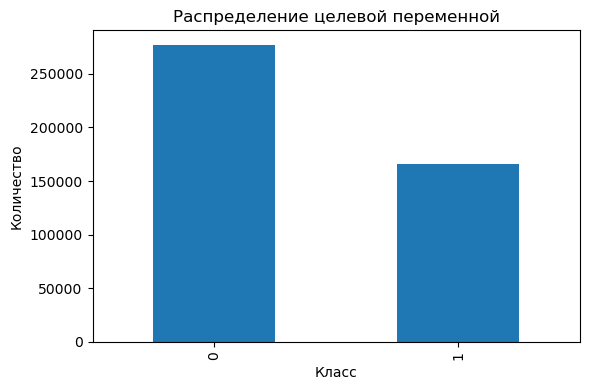


Пропорции классов целевой переменной:
target
0    0.624798
1    0.375202
Name: proportion, dtype: float64


In [4]:
plt.figure(figsize=(6,4))
df['target'].value_counts().plot(kind='bar')
plt.title("Распределение целевой переменной")
plt.xlabel("Класс")
plt.ylabel("Количество")
plt.tight_layout()
plt.show()

print("\nПропорции классов целевой переменной:")
print(df['target'].value_counts(normalize=True))

## Разделение данных

In [24]:
X = df[df.columns[:-1]]
y = df['target']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.176, random_state=42, stratify=y_train_val
)

## Предобработка данных

### Определение выбросов

In [25]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

for col in num_cols:
    original_outliers = ((df[col] < df[col].quantile(0.25) - 1.5*(df[col].quantile(0.75)-df[col].quantile(0.25))) |
                         (df[col] > df[col].quantile(0.75) + 1.5*(df[col].quantile(0.75)-df[col].quantile(0.25)))).sum()
    
    print(f"{col}: выбросов = {original_outliers}")

df.head()

borrow_block_number: выбросов = 0
borrow_timestamp: выбросов = 0
first_tx_timestamp: выбросов = 6911
last_tx_timestamp: выбросов = 0
wallet_age: выбросов = 21683
incoming_tx_count: выбросов = 55306
outgoing_tx_count: выбросов = 54788
net_incoming_tx_count: выбросов = 58678
total_gas_paid_eth: выбросов = 63770
avg_gas_paid_per_tx_eth: выбросов = 20619
risky_tx_count: выбросов = 58978
risky_unique_contract_count: выбросов = 46979
risky_first_tx_timestamp: выбросов = 113801
risky_last_tx_timestamp: выбросов = 93751
risky_first_last_tx_timestamp_diff: выбросов = 24480
risky_sum_outgoing_amount_eth: выбросов = 81507
outgoing_tx_sum_eth: выбросов = 77565
incoming_tx_sum_eth: выбросов = 77329
outgoing_tx_avg_eth: выбросов = 68529
incoming_tx_avg_eth: выбросов = 68637
max_eth_ever: выбросов = 75064
min_eth_ever: выбросов = 65033
total_balance_eth: выбросов = 74703
risk_factor: выбросов = 8
total_collateral_eth: выбросов = 76546
total_collateral_avg_eth: выбросов = 78438
total_available_borrows

,borrow_block_number,borrow_timestamp,wallet_address,first_tx_timestamp,last_tx_timestamp,wallet_age,incoming_tx_count,outgoing_tx_count,net_incoming_tx_count,total_gas_paid_eth,avg_gas_paid_per_tx_eth,risky_tx_count,risky_unique_contract_count,risky_first_tx_timestamp,risky_last_tx_timestamp,risky_first_last_tx_timestamp_diff,risky_sum_outgoing_amount_eth,outgoing_tx_sum_eth,incoming_tx_sum_eth,outgoing_tx_avg_eth,incoming_tx_avg_eth,max_eth_ever,min_eth_ever,total_balance_eth,risk_factor,total_collateral_eth,total_collateral_avg_eth,total_available_borrows_eth,total_available_borrows_avg_eth,avg_weighted_risk_factor,risk_factor_above_threshold_daily_count,avg_risk_factor,max_risk_factor,borrow_amount_sum_eth,borrow_amount_avg_eth,borrow_count,repay_amount_sum_eth,repay_amount_avg_eth,repay_count,borrow_repay_diff_eth,deposit_count,deposit_amount_sum_eth,time_since_first_deposit,withdraw_amount_sum_eth,withdraw_deposit_diff_if_positive_eth,liquidation_count,time_since_last_liquidated,liquidation_amount_sum_eth,market_adx,market_adxr,market_apo,market_aroonosc,market_aroonup,market_atr,market_cci,market_cmo,market_correl,market_dx,market_fastk,market_fastd,market_ht_trendmode,market_linearreg_slope,market_macd_macdext,market_macd_macdfix,market_macd,market_macdsignal_macdext,market_macdsignal_macdfix,market_macdsignal,market_max_drawdown_365d,market_natr,market_plus_di,market_plus_dm,market_ppo,market_rocp,market_rocr,unique_borrow_protocol_count,unique_lending_protocol_count,target
0,7711117,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973049.0,199,438,-239,0.397391,0.000981,0,0,999999999,999999999,0,0.0,975.686105,958.353127,1.174111,1.153253,61.680231,0.060948,58.317987,0.000001,44.479139,0.000000,31.575270,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0,0.0,0.0,0,0.000000,6,44.410991,4026.0,0.0,0.0,0,999999999.0,0.0,22.357432,31.489909,-3.914837,67.777778,7.142857,9.047057,111.965749,19.928594,0.878363,31.02392,80.653832,57.459322,1,0.423859,-3.914837,1.326453,1.406507,-3.468973,1.163425,1.212219,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,0,1,1
1,7711123,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973188.0,200,439,-239,0.399063,0.000983,0,0,999999999,999999999,0,0.0,975.686105,958.510238,1.171292,1.150673,61.680231,0.060948,58.317987,0.004953,44.479139,44.479139,31.418863,31.575270,0.000000,0.0,0.000001,0.000001,0.157110,0.157110,1,0.0,0.0,0,0.157110,6,44.410991,4165.0,0.0,0.0,0,999999999.0,0.0,22.357432,31.489909,-3.914837,67.777778,7.142857,9.047057,111.965749,19.928594,0.878363,31.02392,80.653832,57.459322,1,0.423859,-3.914837,1.326453,1.406507,-3.468973,1.163425,1.212219,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,1,1,1
2,7711126,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973238.0,201,440,-239,0.400895,0.000985,0,0,999999999,999999999,0,0.0,975.686105,958.896402,1.168486,1.148379,61.680231,0.060948,58.317987,0.017103,44.479139,44.479139,31.035236,31.497067,0.000387,0.0,0.002477,0.004953,0.543275,0.271637,2,0.0,0.0,0,0.543275,6,44.410991,4215.0,0.0,0.0,0,999999999.0,0.0,22.357432,31.489909,-3.914837,67.777778,7.142857,9.047057,111.965749,19.928594,0.878363,31.02392,80.653832,57.459322,1,0.423859,-3.914837,1.326453,1.406507,-3.468973,1.163425,1.212219,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,1,1,1
3,7711672,1.557205e+09,0xa7ff0d561cd15ed525e31bbe0af3fe34ac2059f6,1.557191e+09,1.557198e+09,13922.0,8,56,-48,0.604001,0.010786,0,0,999999999,999999999,0,0.0,0.103772,0.803077,0.001596,0.012355,0.000000,0.000000,0.000000,0.000001,0.000767,0.000000,0.000460,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0,0.0,0.0,0,0.000000,1,0.000772,7661.0,0.0,0.0,0,999999999.0,0.0,22.357432,31.489909,-3.914837,67.777778,7.142857,9.047057,111.965749,19.928594,0.878363,31.02392,80.653832,57.459322,1,0.423859,-3.914837,1.326453,1.4065

Признаков, которые дают выбросы, довольно много. Также велико число выбросов у каждого признака. В данном случае, к примеру, выбросы могут означать аномальное поведение. Учитывая специфику данных, удалять или заменять такое количество значений нельзя. Целесообразно использовать модели, устойчивые к выбросам.

### Определение доли категориальных признаков

In [7]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Числовых признаков:", len(num_cols))
print("Категориальных признаков:", len(cat_cols))
print(cat_cols)

Числовых признаков: 76
Категориальных признаков: 1
['wallet_address']


### Анализ категориального признака

Как видно, категориальный признак здесь только один - это адрес кошелька. Он может встречаться в наборе данных повторно, что может говорить о наличии каких-либо закономерностей в данных, паттернов поведения. Поэтому необходимо провести анализ переменной признака и его связей с целевой переменной. Если адрес не несет информацию, то этот признак будет удален.

#### Частота повторов адреса

Количество адресов:  74476
Количество записей:  442961
Частота появлений адреса по убыванию: 
 wallet_address
0x586e32930ac05127de429bd566eaa2758fcbd9bc    2759
0xfac983fce7ef3cee8ffb2ceb967e1b2362aada00    1884
0x654fae4aa229d104cabead47e56703f58b174be4    1743
0xf480fab87c07ec2ddd68a83ec0319bb466b1afa2    1263
0xf9c241b6ad269ac8e8cdb24a540f6cce0ec9e0dd    1091
                                              ... 
0x9363b2cc27898f155ec67677a0ba4c44fdabf05a     260
0x10f37ceb965b477ba09d23ff725e0a0f1cdb83a5     259
0x71a91c9202c8091c62c630ca2de44b333ddcd0d7     259
0x9b857c2c8d4c7318e496c96ec282250e532d64a4     258
0x9dfac9bbe1119da5dcdd7b095db40920cde878ef     257
Name: count, Length: 100, dtype: int64


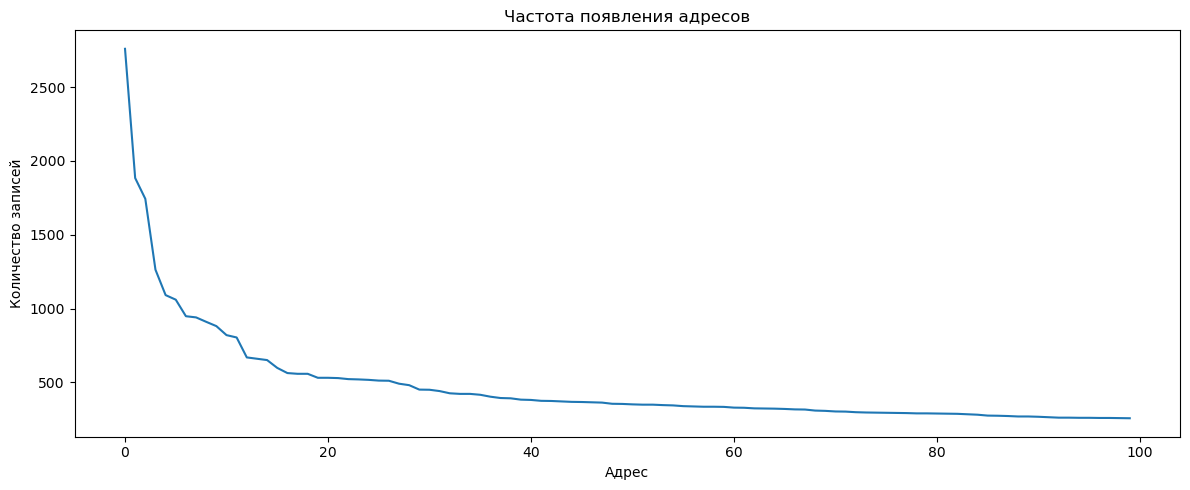

In [8]:
counts = df['wallet_address']
print('Количество адресов: ', counts.nunique())
print('Количество записей: ', df.shape[0])
print('Частота появлений адреса по убыванию: \n', counts.value_counts().head(100))


plt.figure(figsize=(12, 5))
plt.plot(counts.value_counts().head(100).values)
plt.title("Частота появления адресов")
plt.xlabel("Адрес")
plt.ylabel("Количество записей")
plt.tight_layout()
plt.show()

#### Среднее значение целевой переменной в зависимости от адреса

wallet_address
0x7d78677ef3b9e71a5e5696171dc55301244f579c    0.0
0x7d544a853dbcd39a53315e7002f4951a6d2f080d    0.0
0x7d551b4aa5938d18be5c5e9fde7fece9566611ba    0.0
0x7d555aa86324467a25c43e839b9afc543b885d5f    0.0
0x7d573f6c2f3b68f186971deb858e93f70a9a5698    0.0
                                             ... 
0xffff8941130157a0153fb5be2618b257f28d3b55    1.0
0x000000000002e33d9a86567c6dfe6d92f6777d1e    1.0
0x00000008a56679189febe250ea8e651aa3eae054    1.0
0x000000b11f0013d97124fd89d21940e46aab852d    1.0
0x000000c3cfd83e7f9d856bed82231e8a00a1b07f    1.0
Name: target, Length: 74476, dtype: float64


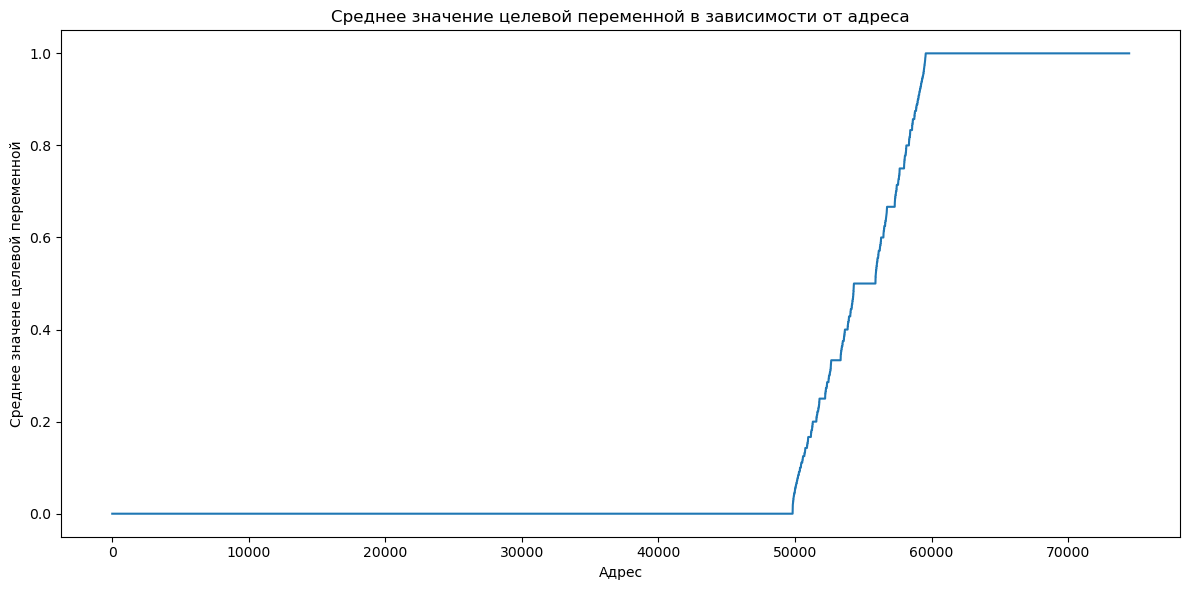

In [9]:
mean_values = df.groupby('wallet_address')['target'].mean().sort_values()

print(mean_values)

plt.figure(figsize=(12, 6))
plt.plot(mean_values.values)
plt.title('Среднее значение целевой переменной в зависимости от адреса')
plt.xlabel('Адрес')
plt.ylabel('Среднее значене целевой переменной')
plt.tight_layout()
plt.show()

#### Энкодинг адресов и Mutual Information по отношению к целевой переменной

In [10]:
he = HashingEncoder(n_components=16)
address_hashed = he.fit_transform(df['wallet_address'])

mi = mutual_info_classif(address_hashed, df['target'])
print("MI по компонентам hashing encoder:\n", mi)
print("Среднее MI:", np.mean(mi))

MI по компонентам hashing encoder:
 [0.00299348 0.00146288 0.00087224 0.00075931 0.         0.00106538
 0.         0.00045283 0.0014314  0.00104914 0.00145444 0.00225687
 0.00169423 0.00100556 0.00094912 0.0021369 ]
Среднее MI: 0.0012239851230868987


#### Обучение логистической регрессии только на переменной адреса и вывод AUC

In [11]:
X = address_hashed

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

preds = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, preds)

print("AUC логистической регрессии по адресу:", auc)

AUC логистической регрессии по адресу: 0.5424249619187056


Из проведенного анализа можно сделать вывод, что адреса кошельков несут определенную информацию, то есть этот признак не может быть просто исключен из набора данных - можно потерять информацию. Для того, чтобы эту информацию можно было использовать в обучении моделей наиболее эффективно, нужно трансформировать признак.
(Долго не мог выбрать, что лучше сделать с адресами: feature engineering на их основе или енкодинг. Выбрал энкодинг.)

### Обработка категориального признака

In [12]:
he = HashingEncoder(n_components=32) # увеличил до 32 
hashed = he.fit_transform(df['wallet_address'])
hashed.columns = [f'hash_{i}' for i in range(hashed.shape[1])]
df_encoded = pd.concat([df.drop(columns=['wallet_address']), hashed], axis=1)
df_encoded.head()

,borrow_block_number,borrow_timestamp,first_tx_timestamp,last_tx_timestamp,wallet_age,incoming_tx_count,outgoing_tx_count,net_incoming_tx_count,total_gas_paid_eth,avg_gas_paid_per_tx_eth,risky_tx_count,risky_unique_contract_count,risky_first_tx_timestamp,risky_last_tx_timestamp,risky_first_last_tx_timestamp_diff,risky_sum_outgoing_amount_eth,outgoing_tx_sum_eth,incoming_tx_sum_eth,outgoing_tx_avg_eth,incoming_tx_avg_eth,max_eth_ever,min_eth_ever,total_balance_eth,risk_factor,total_collateral_eth,total_collateral_avg_eth,total_available_borrows_eth,total_available_borrows_avg_eth,avg_weighted_risk_factor,risk_factor_above_threshold_daily_count,avg_risk_factor,max_risk_factor,borrow_amount_sum_eth,borrow_amount_avg_eth,borrow_count,repay_amount_sum_eth,repay_amount_avg_eth,repay_count,borrow_repay_diff_eth,deposit_count,deposit_amount_sum_eth,time_since_first_deposit,withdraw_amount_sum_eth,withdraw_deposit_diff_if_positive_eth,liquidation_count,time_since_last_liquidated,liquidation_amount_sum_eth,market_adx,market_adxr,market_apo,market_aroonosc,market_aroonup,market_atr,market_cci,market_cmo,market_correl,market_dx,market_fastk,market_fastd,market_ht_trendmode,market_linearreg_slope,market_macd_macdext,market_macd_macdfix,market_macd,market_macdsignal_macdext,market_macdsignal_macdfix,market_macdsignal,market_max_drawdown_365d,market_natr,market_plus_di,market_plus_dm,market_ppo,market_rocp,market_rocr,unique_borrow_protocol_count,unique_lending_protocol_count,target,hash_0,hash_1,hash_2,hash_3,hash_4,hash_5,hash_6,hash_7,hash_8,hash_9,hash_10,hash_11,hash_12,hash_13,hash_14,hash_15,hash_16,hash_17,hash_18,hash_19,hash_20,hash_21,hash_22,hash_23,hash_24,hash_25,hash_26,hash_27,hash_28,hash_29,hash_30,hash_31
0,7711117,1.557197e+09,1.537224e+09,1.557197e+09,19973049.0,199,438,-239,0.397391,0.000981,0,0,999999999,999999999,0,0.0,975.686105,958.353127,1.174111,1.153253,61.680231,0.060948,58.317987,0.000001,44.479139,0.000000,31.575270,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0,0.0,0.0,0,0.000000,6,44.410991,4026.0,0.0,0.0,0,999999999.0,0.0,22.357432,31.489909,-3.914837,67.777778,7.142857,9.047057,111.965749,19.928594,0.878363,31.02392,80.653832,57.459322,1,0.423859,-3.914837,1.326453,1.406507,-3.468973,1.163425,1.212219,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,7711123,1.557197e+09,1.537224e+09,1.557197e+09,19973188.0,200,439,-239,0.399063,0.000983,0,0,999999999,999999999,0,0.0,975.686105,958.510238,1.171292,1.150673,61.680231,0.060948,58.317987,0.004953,44.479139,44.479139,31.418863,31.575270,0.000000,0.0,0.000001,0.000001,0.157110,0.157110,1,0.0,0.0,0,0.157110,6,44.410991,4165.0,0.0,0.0,0,999999999.0,0.0,22.357432,31.489909,-3.914837,67.777778,7.142857,9.047057,111.965749,19.928594,0.878363,31.02392,80.653832,57.459322,1,0.423859,-3.914837,1.326453,1.406507,-3.468973,1.163425,1.212219,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,7711126,1.557197e+09,1.537224e+09,1.557197e+09,19973238.0,201,440,-239,0.400895,0.000985,0,0,999999999,999999999,0,0.0,975.686105,958.896402,1.168486,1.148379,61.680231,0.060948,58.317987,0.017103,44.479139,44.479139,31.035236,31.497067,0.000387,0.0,0.002477,0.004953,0.543275,0.271637,2,0.0,0.0,0,0.543275,6,44.410991,4215.0,0.0,0.0,0,999999999.0,0.0,22.357432,31.489909,-3.914837,67.777778,7.142857,9.047057,111.965749,19.928594,0.878363,31.02392,80.653832,57.459322,1,0.423859,-3.914837,1.326453,1.406507,-3.468973,1.163425,1.212219,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,7711672,1.557205e+09,1.557191e+09,1.557198e+09,13922.0,8,56,-48,0.604001,0.010786,0,0,999999999,999999999,0,0.0,0.103772,0.803077,0.001596,0.012355,0.000000,0.000000,0.000000,0.000001,0.000767,0.000000,0.000460,0.000000,0.000000,0.0,0.0

### Определение корреляции

#### Корреляция с целевой переменной

Корреляция признаков с целевой переменной:


target                         1.000000
risk_factor                    0.426319
liquidation_count              0.147932
liquidation_amount_sum_eth     0.102866
risky_tx_count                 0.097246
                                 ...   
total_available_borrows_eth   -0.046411
last_tx_timestamp             -0.117167
borrow_block_number           -0.118165
borrow_timestamp              -0.118273
time_since_last_liquidated    -0.318610
Name: target, Length: 109, dtype: float64


Признаки с высокой корреляцией с целевой переменной:


target                         1.000000
risk_factor                    0.426319
liquidation_count              0.147932
liquidation_amount_sum_eth     0.102866
risky_tx_count                 0.097246
                                 ...   
total_available_borrows_eth   -0.046411
last_tx_timestamp             -0.117167
borrow_block_number           -0.118165
borrow_timestamp              -0.118273
time_since_last_liquidated    -0.318610
Name: target, Length: 66, dtype: float64

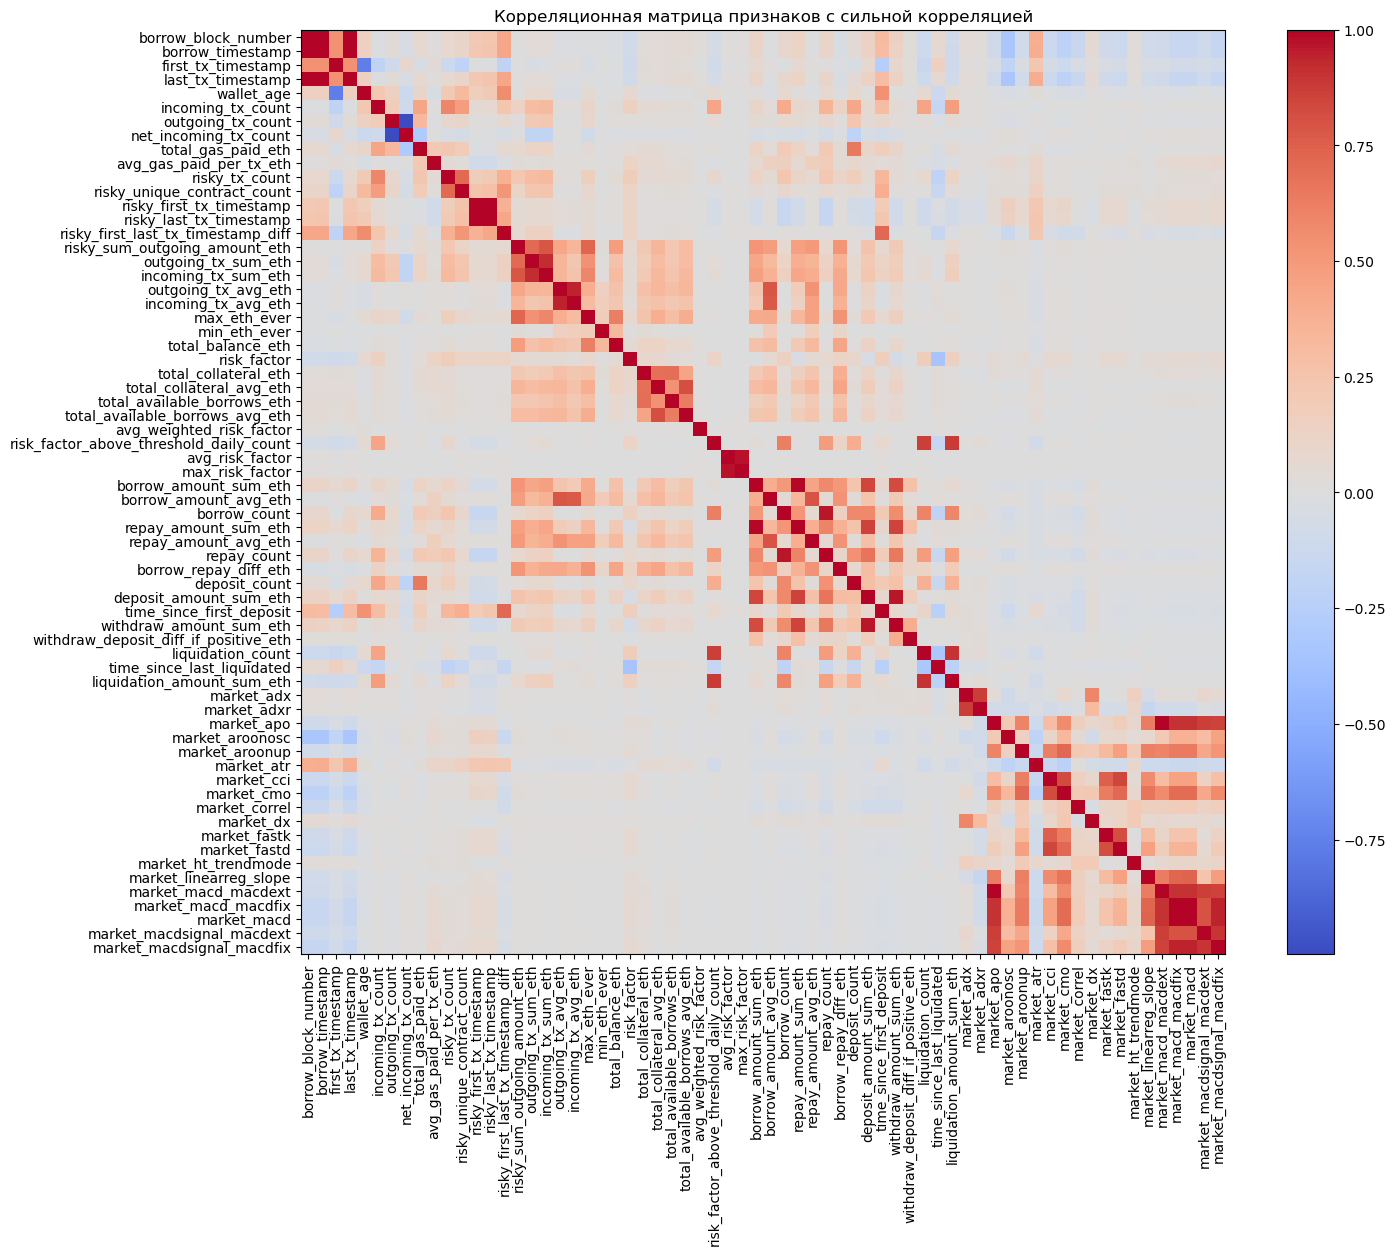

In [13]:
corr_with_target = df_encoded.corr()["target"].sort_values(ascending=False)

print("Корреляция признаков с целевой переменной:")
display(corr_with_target)

threshold = 0.01
important_corr_features = corr_with_target[abs(corr_with_target) > threshold]
print("\nПризнаки с высокой корреляцией с целевой переменной:")
display(important_corr_features)

corr_matrix = df_encoded.corr()
plt.figure(figsize=(16, 12))
subset = corr_matrix.iloc[:66, :66] # по числу сильно коррелирующих признаков
plt.imshow(subset, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(subset.columns)), subset.columns, rotation=90)
plt.yticks(range(len(subset.columns)), subset.columns)
plt.title("Корреляционная матрица признаков с сильной корреляцией")
plt.show()

#### Поиск мультиколлинеарности

In [14]:
def find_high_correlation_pairs(corr_matrix, threshold=0.95):
    correlated_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                correlated_pairs.append((
                    corr_matrix.columns[i],
                    corr_matrix.columns[j],
                    corr_matrix.iloc[i, j]
                ))
    return correlated_pairs

high_corr_pairs = find_high_correlation_pairs(corr_matrix, threshold=0.95)

print(f"\nПары признаков с корреляцией > 0.95 ({len(high_corr_pairs)} найдено):")
for a, b, corr in high_corr_pairs:
    print(f"{a} — {b}: корреляция = {corr:.3f}")


Пары признаков с корреляцией > 0.95 (13 найдено):
borrow_timestamp — borrow_block_number: корреляция = 1.000
last_tx_timestamp — borrow_block_number: корреляция = 1.000
last_tx_timestamp — borrow_timestamp: корреляция = 1.000
net_incoming_tx_count — outgoing_tx_count: корреляция = -0.997
risky_last_tx_timestamp — risky_first_tx_timestamp: корреляция = 0.998
max_risk_factor — avg_risk_factor: корреляция = 0.973
repay_amount_sum_eth — borrow_amount_sum_eth: корреляция = 0.988
repay_count — borrow_count: корреляция = 0.961
withdraw_amount_sum_eth — deposit_amount_sum_eth: корреляция = 0.968
market_macd_macdext — market_apo: корреляция = 1.000
market_macd — market_macd_macdfix: корреляция = 1.000
market_macdsignal — market_macdsignal_macdfix: корреляция = 1.000
market_rocr — market_rocp: корреляция = 1.000


### Определение Mutual Information

first_tx_timestamp          0.272196
max_eth_ever                0.246729
risky_first_tx_timestamp    0.219808
min_eth_ever                0.218365
risk_factor                 0.173433
                              ...   
hash_18                     0.000000
hash_25                     0.000000
hash_28                     0.000000
hash_29                     0.000000
hash_31                     0.000000
Length: 108, dtype: float64


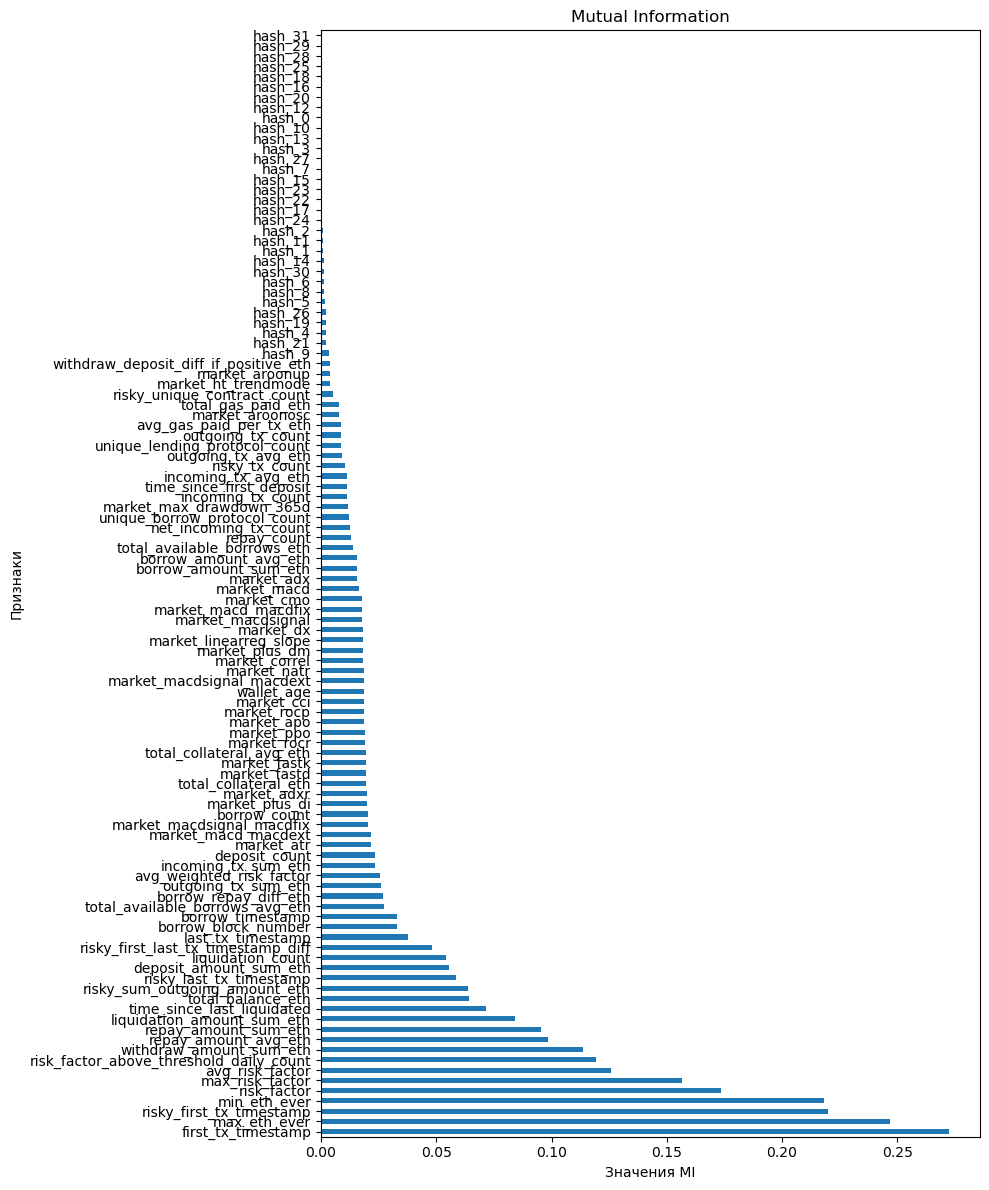

In [15]:
df_sample = df_encoded.sample(100_000, random_state=42)

y = df_sample['target']
X = df_sample.drop(columns=['target'])

mi = mutual_info_classif(X, y, random_state=42, n_neighbors=3)

mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print(mi_series)

plt.figure(figsize=(10, 12))
mi_series.plot(kind='barh')
plt.title("Mutual Information")
plt.xlabel("Значения MI")
plt.ylabel("Признаки")
plt.tight_layout()
plt.show()

### Применение Permutation Importance

#### Обучение модели LightGBM на сэмпле (модель и размер сэмпла выбран случайно, количество объектов в данном случае - 100000).

In [16]:
df_sample = df_encoded.sample(100_000, random_state=42)

y = df_sample['target']
X = df_sample.drop(columns=['target'])

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.176, random_state=42, stratify=y_train_val
)

model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 24770, number of negative: 41150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18053
[LightGBM] [Info] Number of data points in the train set: 65920, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.375758 -> initscore=-0.507591
[LightGBM] [Info] Start training from score -0.507591


LGBMClassifier(random_state=42)

#### Permutation Importance (с LightGBM)

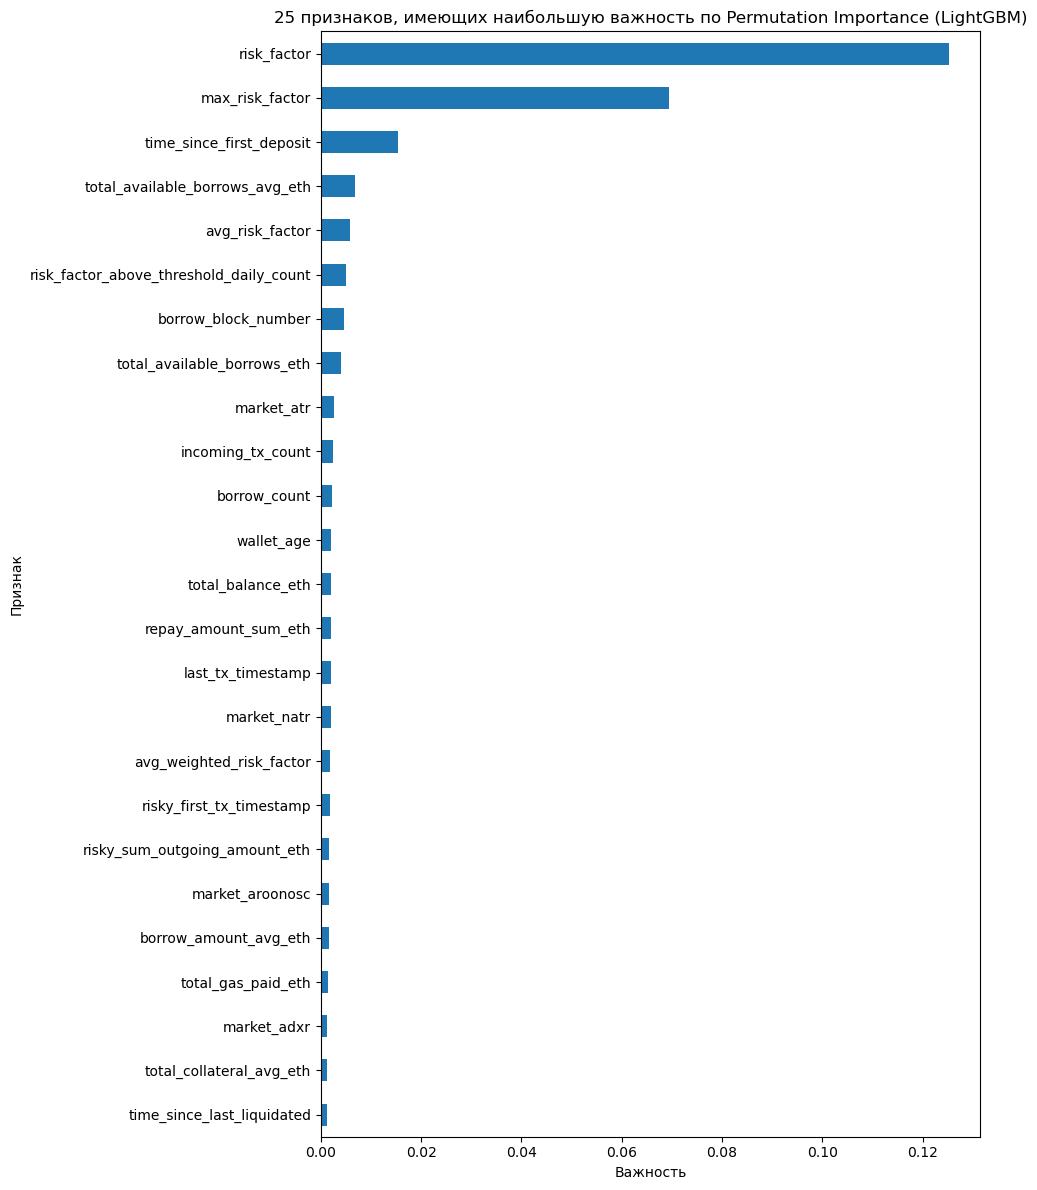

In [17]:
result = permutation_importance(
    model,
    X_test,
    y_test,
    scoring='roc_auc',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

perm_importances = pd.Series(result.importances_mean, index=X.columns)
perm_sorted = perm_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 12))
perm_sorted.head(25).plot(kind="barh")
plt.title("25 признаков, имеющих наибольшую важность по Permutation Importance (LightGBM)")
plt.xlabel("Важность")
plt.ylabel("Признак")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Отбор наиболее важных признаков

In [18]:
high_corr_list = []
for i in high_corr_pairs:
    high_corr_list.append([])
i = 0
for a, b, corr in high_corr_pairs:
    high_corr_list[i].append(a)
    high_corr_list[i].append(b)
    i += 1

print(high_corr_list)

[['borrow_timestamp', 'borrow_block_number'], ['last_tx_timestamp', 'borrow_block_number'], ['last_tx_timestamp', 'borrow_timestamp'], ['net_incoming_tx_count', 'outgoing_tx_count'], ['risky_last_tx_timestamp', 'risky_first_tx_timestamp'], ['max_risk_factor', 'avg_risk_factor'], ['repay_amount_sum_eth', 'borrow_amount_sum_eth'], ['repay_count', 'borrow_count'], ['withdraw_amount_sum_eth', 'deposit_amount_sum_eth'], ['market_macd_macdext', 'market_apo'], ['market_macd', 'market_macd_macdfix'], ['market_macdsignal', 'market_macdsignal_macdfix'], ['market_rocr', 'market_rocp']]


In [19]:
print('important_corr_features\n', important_corr_features)
print('high_corr_pairs\n', high_corr_pairs)
print('mi_series\n', mi_series)
print('perm_importances\n', perm_importances)

important_corr_features
 target                         1.000000
risk_factor                    0.426319
liquidation_count              0.147932
liquidation_amount_sum_eth     0.102866
risky_tx_count                 0.097246
                                 ...   
total_available_borrows_eth   -0.046411
last_tx_timestamp             -0.117167
borrow_block_number           -0.118165
borrow_timestamp              -0.118273
time_since_last_liquidated    -0.318610
Name: target, Length: 66, dtype: float64
high_corr_pairs
 [('borrow_timestamp', 'borrow_block_number', np.float64(0.9998781210987183)), ('last_tx_timestamp', 'borrow_block_number', np.float64(0.9995508012822639)), ('last_tx_timestamp', 'borrow_timestamp', np.float64(0.9996835948764702)), ('net_incoming_tx_count', 'outgoing_tx_count', np.float64(-0.9966436658869285)), ('risky_last_tx_timestamp', 'risky_first_tx_timestamp', np.float64(0.9979920708469963)), ('max_risk_factor', 'avg_risk_factor', np.float64(0.9726529601602051)), ('re

In [20]:
all_features = set()

# Признаки, коррелирующие с таргетом
if hasattr(important_corr_features, "index"):
    all_features |= set(important_corr_features.index)

# Мультиколлинеарные признаки
for a, b in high_corr_list:
    all_features.add(a)
    all_features.add(b)

# Признаки 
all_features |= set(mi_series.index)

# Permutation Importance (Series)
all_features |= set(perm_importances.index)

all_features = list(all_features)

# Таблица весов
scores = pd.DataFrame(index=all_features)
scores["score"] = 0.0

# веса
W_CORR = 1.0
W_MI = 1.5
W_PI = 2.0
W_MULTICOL = -1.0

# Вносим коррелирующие признаки
for f in important_corr_features.index:
    scores.loc[f, "score"] += W_CORR

# MI - нормируем значения в [0,1] и учитываем вес
mi_norm = (mi_series - mi_series.min()) / (mi_series.max() - mi_series.min())
for f in mi_norm.index:
    scores.loc[f, "score"] += mi_norm[f] * W_MI

# Permutation Importance - тоже нормируем
pi_norm = (perm_importances - perm_importances.min()) / (perm_importances.max() - perm_importances.min())
for f in pi_norm.index:
    scores.loc[f, "score"] += pi_norm[f] * W_PI

# Мультиколлинеарность - применяется штраф к обеим признакам
for a, b in high_corr_list:
    scores.loc[a, "score"] += W_MULTICOL
    scores.loc[b, "score"] += W_MULTICOL

# Отбор признаков
scores_sorted = scores.sort_values("score", ascending=False)
print(scores_sorted.head(60))

selected_features = scores_sorted[scores_sorted["score"] > 1.0].index.tolist()
print('Количество отобранных признаков:', len(selected_features))

df_selected = df_encoded[selected_features + ["target"]]

                                            score
risk_factor                              3.955745
first_tx_timestamp                       2.512043
max_eth_ever                             2.373258
min_eth_ever                             2.216880
risk_factor_above_threshold_daily_count  1.739150
repay_amount_avg_eth                     1.553523
liquidation_amount_sum_eth               1.464972
time_since_last_liquidated               1.412625
total_balance_eth                        1.387541
risky_sum_outgoing_amount_eth            1.379201
liquidation_count                        1.299642
risky_first_last_tx_timestamp_diff       1.274421
total_available_borrows_avg_eth          1.260210
avg_weighted_risk_factor                 1.172285
market_atr                               1.162343
borrow_repay_diff_eth                    1.155494
outgoing_tx_sum_eth                      1.145800
total_available_borrows_eth              1.142412
wallet_age                               1.136580


## Отчет о качестве данных

In [23]:
dqr = pd.DataFrame()
dqr['dtype'] = df_selected.dtypes
dqr['missing_count'] = df_selected.isna().sum()
dqr['missing_ratio'] = df_selected.isna().mean()
dqr['nunique'] = df_selected.nunique()

# статистики только для числовых
numeric_stats = df_selected.describe().T[['mean','std','min','max']]
dqr = dqr.join(numeric_stats, how='left')

# флаг "постоянный признак"
dqr['is_constant'] = dqr['nunique'] <= 1

# число выбросов через IQR
outlier_counts = {}
for col in df_selected.select_dtypes(include=['int64','float64']).columns:
    Q1 = df_selected[col].quantile(0.25)
    Q3 = df_selected[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outlier_counts[col] = ((df_selected[col] < lower) | (df_selected[col] > upper)).sum()

dqr['outlier_count'] = dqr.index.map(lambda x: outlier_counts.get(x, np.nan))

# рекомендации (простые правила)
def recommend(row):
    if row['is_constant']:
        return "Удалить (постоянный признак)"
    if row['missing_ratio'] > 0.5:
        return "Удалить (слишком много пропусков)"
    return "Оставить"

dqr['recommended_action'] = dqr.apply(recommend, axis=1)

dqr


,dtype,missing_count,missing_ratio,nunique,mean,std,min,max,is_constant,outlier_count,recommended_action
risk_factor,float64,0,0.0,315354,3.962781e-01,3.233820e-01,2.666672e-24,5.487999e+00,False,8,Оставить
first_tx_timestamp,float64,0,0.0,72713,1.593978e+09,4.485955e+07,1.438270e+09,1.696060e+09,False,6911,Оставить
max_eth_ever,float64,0,0.0,99017,3.293453e+03,2.410610e+04,0.000000e+00,6.994468e+05,False,75064,Оставить
min_eth_ever,float64,0,0.0,91366,5.232591e+01,3.553626e+03,0.000000e+00,5.281967e+05,False,65033,Оставить
risk_factor_above_threshold_daily_count,float64,0,0.0,25516,1.100482e+04,1.401958e+05,0.000000e+00,3.954272e+06,False,91334,Оставить
repay_amount_avg_eth,float64,0,0.0,132459,2.362341e+02,1.532593e+03,0.000000e+00,8.521070e+04,False,75830,Оставить
liquidation_amount_sum_eth,float64,0,0.0,7507,4.309226e+02,4.726303e+03,0.000000e+00,9.644538e+04,False,61909,Оставить
time_since_last_liquidated,float64,0,0.0,61403,8.609501e+08,3.444881e+08,8.000000e+00,1.000000e+09,False,62069,Оставить
total_balance_eth,float64,0,0.0,305231,6.943873e+02,1.172078e+04,0.000000e+00,6.994468e+05,False,74703,Оставить
risky_sum_outgoing_amount_eth,float64,0,0.0,225854,2.312860e+04,2.230375e+05,0.000000e+00,1.294037e+07,False,81507,Оставить


In [1]:
df_selected.to_parquet("selected_data.parquet", index=False)

NameError: name 'df_selected' is not defined

## Заключение

Текущий набор данных имеет размерность: 442921 строка и 77 признаков. Все признаки, кроме одного (wallet_adress) представлены числовым форматом. На основе этого единственного признака, представленного в виде текста, было создано несколько числовых признаков с помощью инструмента HashingEncoder, а сам признак был удален.
В наборе фигурирует большое количество выбросов значений многих переменных, но в силу специфики данных эти выбросы удалять нельзя, так как они могут являться свидетельством аномального поведения и поэтому нести значимое количество информации. Для модели логистической регрессии может быть применено масштабирование признаков для исключения влияния выбросов на обучение.
В процессе анализа был выявлен некоторый дисбаланс целевой переменной, а также наличие мультиколлинеарности многих признаков. На основе сочетания выводов таких методов отбора, как корреляция, мультиколлинеарность, Mutual Information и Permutation Importance, было удалено 25 признаков. Эти признаки не несли значительного количества информации, поэтому их удаление не повлияет существенным образом на обучение и работу модели.